### Training an Image Classifier 
The following code has been adapted from various sources including: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-3-CNNs-and-image-classification/train-image-classifier-from-pretrained.ipynbdebugged andareas have been debugged using GPT.
In this notebook I clean my image dataset, create new data points for each image and implement these changes back into my 'emtional-class-datasheet.csv'. 
Additionally, I implement ResNet and VisionTransformer for training.

In [2]:
%pip install pandas
%pip install opencv-python
%pip install torch torchvision
%pip install numpy
%pip install matplotlib
%pip install pytesseract
%pip install scikit-learn
%pip install dlib
%pip install opencv-python
%pip install cmake
%pip install --upgrade numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.
  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.2-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached MarkupSafe-2.1.5-cp311-cp311-macosx_10_9_universal2.whl.metadata (3.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 5.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 4.

In [ ]:
%pip uninstall opencv-python
%pip uninstall opencv-python-headless



In [ ]:
import sys
sys.setrecursionlimit(1500)


In [3]:
import os
import pandas as pd
import cv2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
import pytesseract

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split



In [6]:
# Double check my class datasets are recognised:
os.listdir('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset')

['neutral-face', 'happy-face', 'sad-face', 'angry-face']

In [ ]:
# I had an unexpected file in my class dataset ('.ipynb_checkpoints') and wanted to double chheck the conentss, if any.
directory_path = '/Users/nixi/Desktop/Final thesis folder 24/AI-for-Media-project-23-24/my-classification-dataset'

# List the contents of the directory
contents = os.listdir(directory_path)

if '.ipynb_checkpoints' in contents:
    checkpoint_path = os.path.join(directory_path, '.ipynb_checkpoints')
    checkpoint_contents = os.listdir(checkpoint_path)
    print(checkpoint_contents)
else:
    print(".ipynb_checkpoints directory does not exist in the specified directory.")
    # This created an empty list, nothing to worry about!

## Data Pre-Processing
### A. Remove any duplicates in 'my-classification-dataset' 
I had noticed a few duplicates when woorking with the same custom dataset for another data science module for k-means cluster experimentation. The private repository can be found here: https://git.arts.ac.uk/23002156/Intro-Data-Science-Portfolio-2024.
### B. Isolating faces from images ( particularly for magazine data and to remove solely text data thta may have been collected during sampling)
I could exclude images with text using a text detector, but this may reduce the dataset significantly.
Use Haar Cascade classifier ( which uses feature based object detection) available from: https://github.com/opencv/opencv/tree/4.x/data/haarcascades.
### C. Create 'emotional-class-datasheet.csv', considering any new changes


In [7]:
%pip install dlib

  Using cached dlib-19.24.6.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.6-cp311-cp311-macosx_12_0_arm64.whl size=3209356 sha256=c32113db37b3997a43c334beadbc87f256b64c10f0fd9afba9a61cd55782f9e0
  Stored in directory: /Users/nixi/Library/Caches/pip/wheels/fe/c7/1f/c778b9f7cc6d8d0da4f6697f619f9eb5a49d54d2a2c8267f3c
Successfully built dlib
Note: you may need to restart the kernel to use updated packages.


In [20]:
import dlib
import cv2
import pandas as pd
import os

In [50]:

# The following code has been adapted from Week 4,Sensing bodies : https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/commit/981594f418f30d02fcff4998cc93f39d4108b608 and debugged using GPT
# Isolate faces using Haar Casscade Classifier, I learnt how to implement this classifier from: https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php

# Initialize the face cascade and shape predictor
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
predictor_path = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

# Path to the directory containing your images
directory_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset'

data = []

# Iterate over all files in the directory, as adapted from: https://www.slingacademy.com/article/python-how-to-iterate-over-all-files-in-a-directory/
for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if filename.lower().endswith('.jpg') or filename.lower().endswith('.png'):
            # Build the full file path
            image_path = os.path.join(root, filename)
            print("Processing image:", image_path)
            
            # Load the image
            image = cv2.imread(image_path)
            
            # Check if the image was loaded properly
            if image is None:
                print(f"Error loading image {image_path}. Skipping...")
                continue

            # Convert the image to grayscale for feature extraction, which helps to reduce any noise when the images are processed and hopefully better training.
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Detect faces in the image
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # If no faces are detected
            if len(faces) == 0:
                print("No faces detected in", image_path)
                # Remove the file from the directory
                os.remove(image_path)
                print(image_path, "removed from dataset")
                continue

            # Extract emotion class from the directory path
            emotion_class = os.path.basename(root)

             # Next I need to find eye, mouth and nose landmark points for each image. I started with creating variables to store the data.
            # Code debugged  using GPT and adapted from https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-4-Sensing-bodies and https://dontrepeatyourself.org/post/how-to-detect-face-landmarks-with-dlib-python-and-opencv/?utm_content=cmp-true
            for (x, y, w, h) in faces:
                face_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
                landmarks = predictor(gray, face_rect)

                # Initialize lists for landmarks
                eyes_x, eyes_y, nose_x, nose_y, mouth_x, mouth_y = [], [], [], [], [], []

                # Extract landmark coordinates for eyes
                for n in range(36, 48):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    eyes_x.append(x)
                    eyes_y.append(y)

                # Extract landmark coordinates for nose
                for n in range(27, 35):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    nose_x.append(x)
                    nose_y.append(y)

                # Extract landmark coordinates for mouth
                for n in range(48, 68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    mouth_x.append(x)
                    mouth_y.append(y)

                # Append extracted features to the list
                data.append({
                    'Image': filename, 
                    'EmotionClass': emotion_class, 
                    'TotalFaceArea': w * h,
                    'EyesX': eyes_x, 
                    'EyesY': eyes_y, 
                    'NoseX': nose_x, 
                    'NoseY': nose_y,
                    'MouthX': mouth_x, 
                    'MouthY': mouth_y
                })

# Create a DataFrame to store the data
df = pd.DataFrame(data)

# Write the data to a CSV file
df.to_csv('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/facial_landmarks_data.csv', index=False)

# Indicate that processing is complete
print("Data processing complete.")

Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_370491506865098460.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655987.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655978.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_31806741112770968.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002237.210_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655950.jpg
Processing image: /Users/nixi/D

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_359232507787505599.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_119134352637236918.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_539657967902865008.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986322.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986444.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751656136.jpg
Processing image: /Users/nixi/Desktop

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_161003755421340538.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986197.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986424.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_90635011241421336.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-05T231324.567_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986168.png
Processing image: /Users/nixi/D

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002223.405_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986377_5717460601892851017.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/26559693133_d2eed3bb11_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_648870258845585156.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002057.649_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_219832025557833299.jpg
Proc

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_369928556910619824.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_19914423346149273.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_15199717488061676.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655894.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986186.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986435.jpg
Processing image: /Users/nixi/Desktop/F

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/26639986531_85009ed7d9_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_55098795448188844.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_201043570861003667.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_115967759147805878.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_27373510229639307.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655695.jpg
Processing image: /Users/nixi/Desktop/Fi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_13651605104165851.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655864.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_207728601556170946.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_16888567431902409.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_75646468732444007.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T003055.324_face.png
Processing image: /Users/nixi/Deskt

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_21321798219088645.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986374.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986406.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_49117452180873979.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_604960162478979903.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002318.349_face.png
Processing image: /Users/nixi/Des

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_557461260112152234.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_426645764716761395.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_365706432218119011.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_55943220344344313.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_909938299705021705.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_703756187362095.jpg
Processing image: /Users/nixi/Desktop/Final-

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655692.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T003431.096_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_3237030973936278.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655645.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1900024838020632.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_669206825900764519.png
Processing image: /Users/nixi/Deskt

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_68747861412.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1407443619132982.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_50032245853397464.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002854.499_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986460.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_27443878972332884.jpg
Processing image: /Users/nixi/Desktop/Final

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352442929124.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352434831694.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253069879330.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_569494315351356831.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253069693496.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/364961554_995f805895_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-fo

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_412149803383867650.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071690670.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253082826830.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/images - 2020-11-06T000332.733_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352434484842.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071957871.jpg
Processing image: /Users/nixi/Desktop/Final-t

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352434498228.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_429812358183417538.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_43136108914764385.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071829071.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253091264369.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253070398157.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-fo

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352443351347.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_880735270883642827.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253070148038.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954848096570.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images (66)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_213709944804842420.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Me

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S137_005_00000027.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195225.477_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T201748.373_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_370491506819607241.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847624045.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S137_005_00000025.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Medi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_157274211992048980.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195135.120_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173293.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_115123334204224119.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/40279718253_963df106fa_b_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/40279718253_963df106fa_b_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-M

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195218.438_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200618.460_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S042_002_00000014.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195122.342_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S011_002_00000021.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T004438.329_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847463562.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S504_006_00000017.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954848808859.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T000459.311_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T000459.311_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T000459.311_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thes

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T001935.121_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954851476105.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954862436725.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173686.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S046_001_00000025.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S506_006_00000042.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-proj

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S042_002_00000015.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195919.477_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954861971831.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954848808904.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847624082.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847623921.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/2Q__ (9)_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/2Q__ (9)_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173395.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954857756553.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195850.571_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T005356.659_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195814.981_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T002858.568_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173416.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_430516045647374564.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173364.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_115123334203889653.jpg
Processing image: /Users/nixi/Desktop/Final-thes

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173400.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_68747417382.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_115123334203987126.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T005506.984_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/7056425327_e9e2d4f40a_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T002114.703_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folde

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/2Q__ (1)_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/2Q__ (1)_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/2Q__ (1)_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/13895174901_768e9f188c_n_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/13895174901_768e9f188c_n_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/13895174901_768e9f188c_n_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-cla

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954861918350.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954855215952.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954849026445.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195803.074_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T003610.309_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T003610.309_face.png
/Users/nixi/Desktop/Final-thesis-folder-

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195112.336_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T004446.047_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T004446.047_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T004446.047_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954849026444.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195821.246_face.png
Processing image: /User

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200456.209_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T181814.155_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T003023.841_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T003023.841_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T003023.841_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200442.791_face.png
Processing image

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954849171341.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954861918530.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173476.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173310.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/5955746030_6631810c14_n_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/5955746030_6631810c14_n_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-pro

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954858943626.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847624061.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_430516045647629793.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T201637.833_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_4925880836539545.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_370491506839079623.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-2

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T004114.019_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T004114.019_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_38210296830446889.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173300.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_281543711558159.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200447.793_face.png
Processing image: /Users/nixi/Desktop/Fi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847463597.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847463583.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173699.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847674912.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200124.517_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_426223552253157565.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folde

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173288.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195104.813_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T200531.058_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_115123334203889595.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_578008933449277941.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_325807354308407925.jpg
Processing image: /Users/nixi/Desktop/Final-t

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/31779682004_a9efa7d01e_n_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/31779682004_a9efa7d01e_n_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_83879611804351000.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images (72)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_37647346877742493.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751986916.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004052.313_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_643592603025651211.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S111_006_00000008.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/372662640_e8dc799d8b_b_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/372662640_e8dc799d8b_b_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/372662640_e8dc799d8b_b_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-fo

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S089_003_00000036.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_295196950588592714.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T182741.814_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_299559812727691709.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T201650.497_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_382172718353773165.jpg
Processing image: /Users/nixi/Desktop/Final-thesi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004500.225_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003428.506_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_2814818511247376.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003443.953_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003443.953_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003443.953_face.png removed from dataset
Processing im

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images (78)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_141652350750237494.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_719098265522201281.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S050_004_00000020.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/9k_ (3)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S029_001_00000018.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classificat

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/11647173796_033ff06112_n_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/11647173796_033ff06112_n_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/11647173796_033ff06112_n_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004141.712_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T000539.994_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T000539.994_face.png
/Users/nixi/Desktop

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S999_001_00000016.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751986766.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T005414.837_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003605.320_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003605.320_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003605.320_face.png removed from dataset
Processing image: /Users/nix

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T005518.831_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751987096.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751987082.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T192320.343_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T184231.365_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_295196950589379278.jpg
Processing image: /Users/nixi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004445.396_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S090_007_00000014.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/2Q__ (1)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_548594798344565166.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S136_005_00000010.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_563018694113632.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T182427.183_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004613.411_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_4785143349603963.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004129.400_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003531.624_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T002925.726_face.png
No faces detected i

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T181818.219_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003549.598_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003549.598_face.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003549.598_face.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S109_003_00000017.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S082_005_00000017.png
Processing image: /Users/nixi/Desktop/Fi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751986920.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_83738874315289727.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_5770305764491637.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_25262447902361395.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_577094139781377675.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_451626668854977122.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-fold

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S067_004_00000023.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_5559199536134991.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S037_003_00000020.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_636626097321605495.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S075_008_00000011.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T005439.473_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-projec

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T004643.968_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S504_001_00000021.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_202873158208793689.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S126_008_00000029.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_5699937023079665.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003621.884_face.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-2

In [ ]:
# Code adapted from: https://www.geeksforgeeks.org/reading-image-opencv-using-python/?ref=lbp 
# Remove Duplicates:

import hashlib

folder_path = '/Users/nixi/Desktop/Final thesis folder 24/AI-for-Media-project-23-24/my-classification-dataset'

# Load CSV file
csv_file_path = 'emotional-class-datasheet.csv'
data = pd.read_csv(csv_file_path)

# Initialize a dictionary to store file hashes
file_hashes = {}

# Iterate through the subfolders
for subdir, dirs, files in os.walk(folder_path):
    # Iterate through the files in each subfolder
    for filename in files:
        file_path = os.path.join(subdir, filename)
        
        # Calculate the hash of the file content
        with open(file_path, 'rb') as file:
            file_hash = hashlib.md5(file.read()).hexdigest()
        
        # Check for duplicates based on file content
        if file_hash in file_hashes.values():
            # Remove duplicate file
            os.remove(file_path)
            # Remove corresponding row from CSV
            data = data[data['Image URL'] != file_path]
        else:
            file_hashes[filename] = file_hash

# Save the updated data to the CSV file
data.to_csv(csv_file_path, index=False)

##### Additional images derrived from https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition?select=anger to ensure the ratio of images for each emotional class ,after cleaning, is over 1000 at the least.This aids in removing bias and better overall classification.

In [51]:
# How has this impacted my ratio?
emotional_classes = ['neutral-face', 'happy-face', 'sad-face', 'angry-face']

dirrectory = "/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset"

#Instantiate for counts
class_counts = {}

for emotion in emotional_classes:
    class_dir = os.path.join(dirrectory, emotion)
    # Count the number of image files in the class directory
    class_counts[emotion] = len([file for file in os.listdir(class_dir) if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))])


# Print out the value of each folder
for emotion_class, count in class_counts.items():
    print(f"Emotional class: {emotion_class}, Total images: {count}")

Emotional class: neutral-face, Total images: 968
Emotional class: happy-face, Total images: 1037
Emotional class: sad-face, Total images: 774
Emotional class: angry-face, Total images: 842


In [52]:
df_cleaned = df.dropna(subset=['EmotionClass'])

#df = df.drop(columns=['Path', 'NumFaces'])

# Step 2: Inspect NaN values
print("NaN values in each column before cleaning:")
print(df.isna().sum())

# Step 3: Drop rows with NaN values in the 'EmotionClass' column
df_cleaned = df.dropna(subset=['EmotionClass'])

# Step 4: Fill remaining NaN values in specified columns
df_cleaned = df_cleaned.fillna({
    'EyesX': '',
    'EyesY': '',
    'NoseX': '',
    'NoseY': '',
    'MouthX': '',
    'MouthY': ''})

df_cleaned


NaN values in each column before cleaning:
Image            0
EmotionClass     0
TotalFaceArea    0
EyesX            0
EyesY            0
NoseX            0
NoseY            0
MouthX           0
MouthY           0
dtype: int64


,Image,EmotionClass,TotalFaceArea,EyesX,EyesY,NoseX,NoseY,MouthX,MouthY
0,pinterest_370491506865098460.png,neutral-face,9801,"[775, 778, 782, 787, 782, 777, 809, 813, 819, ...","[51, 49, 49, 52, 53, 53, 53, 51, 51, 53, 55, 55]","[795, 794, 792, 790, 784, 787, 791, 797]","[52, 59, 65, 73, 79, 81, 82, 81]","[779, 782, 787, 791, 795, 802, 810, 802, 795, ...","[95, 92, 90, 91, 90, 93, 98, 103, 105, 104, 10..."
1,pinterest_370491506865098460.png,neutral-face,30976,"[366, 375, 386, 393, 385, 375, 432, 441, 450, ...","[74, 70, 70, 78, 79, 78, 81, 75, 76, 82, 84, 83]","[422, 426, 430, 434, 406, 416, 425, 433]","[77, 92, 108, 124, 134, 136, 138, 136]","[393, 407, 417, 423, 429, 431, 432, 429, 426, ...","[163, 157, 154, 157, 155, 160, 167, 162, 161, ..."
2,pinterest_1105774514751655987.jpg,neutral-face,47524,"[104, 113, 125, 135, 124, 112, 188, 196, 208, ...","[224, 218, 217, 223, 228, 229, 217, 207, 204, ...","[161, 164, 165, 167, 154, 162, 170, 177]","[220, 237, 253, 270, 279, 280, 281, 278]","[143, 152, 161, 171, 181, 193, 205, 196, 185, ...","[308, 301, 297, 299, 295, 296, 299, 311, 316, ..."
3,pinterest_1105774514751655978.jpg,neutral-face,77284,"[173, 187, 203, 216, 201, 185, 283, 298, 314, ...","[241, 234, 235, 246, 248, 247, 247, 237, 237, ...","[251, 252, 252, 253, 222, 236, 251, 265]","[242, 264, 285, 308, 320, 323, 327, 324]","[198, 218, 237, 249, 262, 281, 300, 283, 264, ...","[365, 357, 351, 355, 351, 358, 365, 387, 393, ..."
4,pinterest_31806741112770968.jpg,neutral-face,16384,"[438, 443, 448, 453, 448, 443, 476, 480, 485, ...","[297, 294, 293, 296, 297, 297, 299, 297, 298, ...","[465, 465, 466, 467, 456, 460, 465, 470]","[294, 302, 310, 318, 325, 327, 329, 328]","[447, 454, 460, 465, 469, 474, 478, 473, 468, ...","[346, 342, 340, 342, 342, 345, 350, 350, 350, ..."
...,...,...,...,...,...,...,...,...,...
4290,images - 2020-11-06T184530.833_face.png,angry-face,33489,"[53, 64, 76, 88, 76, 64, 141, 152, 165, 176, 1...","[76, 71, 71, 78, 78, 78, 79, 71, 71, 77, 78, 79]","[116, 116, 116, 115, 86, 99, 114, 129]","[73, 85, 97, 109, 120, 124, 128, 125]","[63, 79, 100, 113, 128, 147, 161, 146, 127, 11...","[155, 142, 139, 141, 139, 144, 159, 173, 178, ..."
4291,S037_003_00000022.png,angry-face,1600,"[12, 14, 16, 18, 16, 14, 28, 30, 33, 35, 33, 30]","[20, 19, 18, 20, 20, 20, 20, 19, 19, 20, 20, 20]","[23, 23, 23, 23, 19, 21, 23, 25]","[18, 22, 25, 29, 31, 31, 32, 31]","[16, 19, 21, 23, 25, 28, 31, 28, 26, 24, 22, 1...","[36, 36, 35, 36, 35, 36, 36, 38, 39, 39, 39, 3..."
4292,images - 2020-11-06T202901.714_face.png,angry-face,39601,"[36, 51, 66, 80, 66, 51, 150, 164, 178, 191, 1...","[84, 81, 80, 85, 88, 89, 86, 82, 83, 87, 92, 90]","[118, 117, 118, 118, 90, 103, 116, 129]","[79, 97, 115, 134, 145, 148, 151, 148]","[71, 88, 105, 115, 127, 141, 157, 141, 127, 11...","[186, 180, 177, 180, 177, 181, 185, 189, 190, ..."
4293,S067_004_00000021.png,angry-face,1600,"[10, 12, 15, 18, 15, 12, 29, 31, 34, 37, 35, 32]","[19, 17, 17, 19, 20, 20, 19, 17, 17, 18, 20, 20]","[23, 23, 23, 23, 20, 22, 23, 25]","[18, 21, 24, 27, 31, 32, 32, 32]","[16, 19, 21, 23, 25, 28, 32, 28, 25, 23, 21, 1...","[39, 38, 37, 38, 37, 38, 39, 41, 42, 42, 42, 4..."


In [46]:
# Reduce the sample to remove bias in model training to predict emotions.

import random
import shutil

emotional_classes = ['neutral-face', 'happy-face', 'sad-face', 'angry-face']

# Directory containing the images
directory = "AI-for-Media-project-23-24/my-classification-dataset"

# Output directory for reduced image sets
output_dir = "/notebooks/AI-for-Media-project-23-24/reduced-dataset"
os.makedirs(output_dir, exist_ok=True)

# Count and reduce images
for emotion in emotional_classes:
    class_dir = os.path.join(directory, emotion)
    images = [file for file in os.listdir(class_dir) if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))]
    
    # Randomly select up to 1500 images
    selected_images = random.sample(images, min(len(images), 1500))
    
    # Create output directory for the emotion class
    class_output_dir = os.path.join(output_dir, emotion)
    os.makedirs(class_output_dir, exist_ok=True)
    
    # Copy selected images to the output directory
    for image in selected_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(class_output_dir, image))
    
    # Print out the value of each folder
    print(f"Emotional class: {emotion}, Total images after reduction: {len(selected_images)}")

print("Image selection and saving completed.")

OSError: [Errno 30] Read-only file system: '/notebooks'

## Make the training and validation set for training
I experimented with how to best split my dataset into train and validation sets, while maintaining the directory structure. I tried manually doing so, then using 'random_state= 42' as used in the class workbook which split data in a deterministic way. (See https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-3-CNNs-and-image-classification).

In [58]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset'
output_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24'
train_ratio = 0.8

# Create output directories for train and validation sets
train_output_path = os.path.join(output_path, 'train')
val_output_path = os.path.join(output_path, 'validation')
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# Dictionary to hold file paths by emotion class
class_files = {}

# Collect image and label files by emotion class
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.txt'):
            class_name = os.path.basename(root)
            if class_name not in class_files:
                class_files[class_name] = {'images': [], 'labels': []}
            file_path = os.path.join(root, f)
            if f.endswith('.jpg') or f.endswith('.png'):
                class_files[class_name]['images'].append(file_path)
            elif f.endswith('.txt'):
                class_files[class_name]['labels'].append(file_path)

# Perform train-test split for each class separately and copy the files
for class_name, files in class_files.items():
    train_image_files, val_image_files = train_test_split(files['images'], test_size=1 - train_ratio, random_state=42)
    train_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in train_image_files]
    val_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in val_image_files]

    # Copy training image and label files to the appropriate directory
    for train_image_file in train_image_files:
        relative_dir = os.path.relpath(os.path.dirname(train_image_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_image_file, os.path.join(target_dir, os.path.basename(train_image_file)))

    for train_label_file in train_label_files:
        relative_dir = os.path.relpath(os.path.dirname(train_label_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_label_file, os.path.join(target_dir, os.path.basename(train_label_file)))

    # Copy validation image and label files to the appropriate directory
    for val_image_file in val_image_files:
        relative_dir = os.path.relpath(os.path.dirname(val_image_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_image_file, os.path.join(target_dir, os.path.basename(val_image_file)))

    for val_label_file in val_label_files:
        relative_dir = os.path.relpath(os.path.dirname(val_label_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_label_file, os.path.join(target_dir, os.path.basename(val_label_file)))

print("Data split into train and validation sets for each class.")

Data split into train and validation sets for each class.


In [67]:
# I had a folder called 'ipynb_checkpoints' that was considered a 7th emotional class but had no data within. This prevented the above code from working because file formats listed were not found at all.
# This seemed to be a reoccuring issue for image classification processes for other python users. This was found out at: https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/27.
# I resorted to deleting the file overall and updating the training ( below code) from  7 classes to 6 and re-running training. ( code adapted from: https://stackoverflow.com/questions/61207135/how-can-i-ignore-or-remove-ipynb-checkpoints-in-colab)
dataset_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split' 

# Remove the .ipynb_checkpoints directory if it exists
ipynb_checkpoints_dir = os.path.join(dataset_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    os.rmdir(ipynb_checkpoints_dir)
    print(".ipynb_checkpoints directory deleted successfully.")
else:
    print(".ipynb_checkpoints directory not found.")

.ipynb_checkpoints directory not found.


In [63]:
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached charset_normalizer-3.3.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (33 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 MB 4.2 MB/s eta 0:00:0000:0100:02
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 4.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 4.1 MB/s eta 0:00:0000:0100:01
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Code adapted from https://www.kaggle.com/code/akshitmadan/emotion-classification-cnn-using-keras.
picture_size = 150

folder_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/'

no_of_classes = 4 # total number of subfolders in my dataset ( each emotion)

batch_size = 300
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size=(picture_size, picture_size),
                                              color_mode="grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

test_set = datagen_val.flow_from_directory(folder_path + "validation",
                                           target_size=(picture_size, picture_size),
                                           color_mode="grayscale",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 2819 images belonging to 4 classes.
Found 707 images belonging to 4 classes.


### Train validation and training image transforms
This includes data augmentation using PyTorch and ImageDataGenerator from Kera, which are useful in creating variations in the image data. The following code has also been adapted from class week 3 CNN notebook as stated above.


In [74]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


Shape of train_numpy: (64, 150, 150, 1)


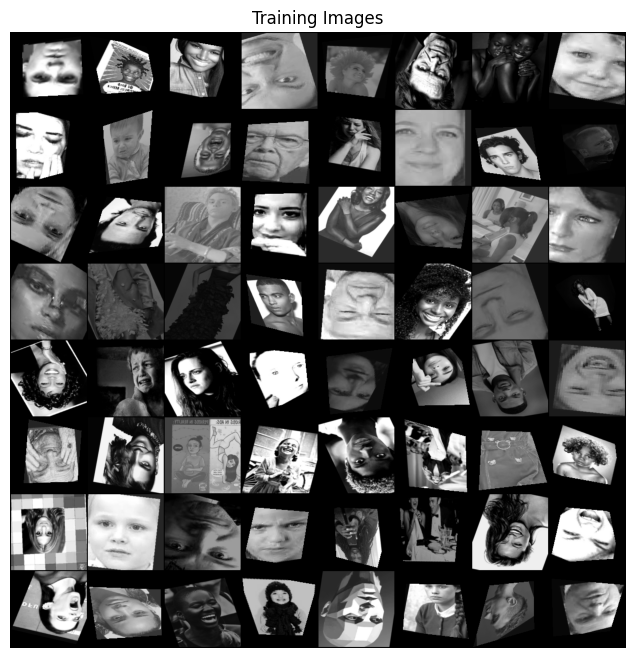

In [76]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define train_transform for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your training dataset
train_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train'

# Load the training dataset
train_set = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)

# Define DataLoader for batch loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Get a batch of training images
real_batch = next(iter(train_loader))
tensor_batch = real_batch[0]

# Convert a batch of PyTorch tensors to NumPy arrays
# Convert PyTorch tensors to NumPy arrays (had to convert PyTorch tensor to NumPy array, due to incorrect data processing.
# I used code adapted from: https://www.geeksforgeeks.org/how-to-convert-pytorch-tensor-to-numpy-array/ then debugged with GPT after my own attempt.

train_numpy = tensor_batch.numpy()
train_numpy = np.moveaxis(train_numpy, 1, -1)
print("Shape of train_numpy:", train_numpy.shape)

# Plot some training images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

# Display the grid of images 
# The below code was adapted from https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t, which explained the same issue where matplotlib was not displaying my images because of image sizing differences.
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

Shape of val_numpy: (707, 150, 150, 1)


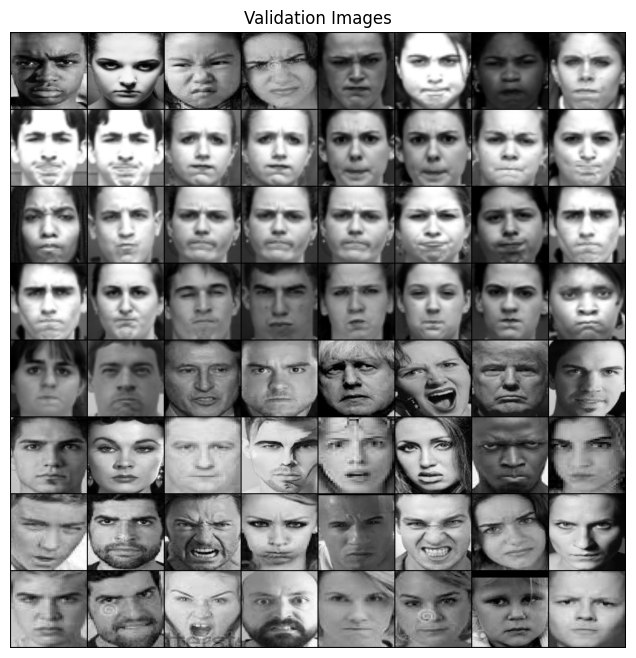

In [83]:
# Validation image transforms using the similar approach as train
import torchvision.datasets as datasets

val_transform = transforms.Compose([
    torchvision.transforms.Resize((150, 150)), 
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your validation dataset
val_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/validation'  # Path to the directory containing class directories

val_set = torchvision.datasets.ImageFolder(root=val_path, transform=val_transform)

# Convert to NumPy array for data processing ( same as the above training data)
# I had an issue with the dimensions of my images
val_numpy = np.array([x.numpy() for x, _ in val_set])

# Code adapted from: https://stackoverflow.com/questions/57438392/rearranging-axes-in-numpy after an error with the shape of val_numpy (374, 1, 150, 150).
    # The error: 'sequential_9". I have an error 'ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 150, 150, 1), found shape=(None, 1, 150, 150)'
val_numpy = np.moveaxis(val_numpy, 1, -1)

# Print shape 
print("Shape of val_numpy:", val_numpy.shape)

# Define DataLoader for batch loading
batch_size = 64
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Get a batch of validation images
real_batch = next(iter(val_loader))

# Convert torch tensor to numpy array and permute the dimensions to match (batch_size, height, width, channels)
tensor_batch = real_batch[0]

# Plot some validation images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validation Images")

# The code below displays the batch of images using matplotlib
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

### Training model

In [137]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Ensure the data is a numpy array and has the correct shape with 4 dimensions
if len(train_numpy.shape) == 3:
    train_numpy = np.expand_dims(train_numpy, axis=-1)

if len(val_numpy.shape) == 3:
    val_numpy = np.expand_dims(val_numpy, axis=-1)

class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}


# Convert to float32 (recommended for neural networks)
#train_numpy = train_numpy.astype('float32')
train_numpy = np.array(train_numpy)
#val_numpy = val_numpy.astype('float32')
val_numpy = np.array(val_numpy)

# Normalize the input data
train_numpy /= 255.0
val_numpy /= 255.0

# Convert labels to float32 to match the expected format for the model
#train_labels_encoded = train_labels_encoded.astype('float32')
train_labels_encoded = np.array(train_labels_encoded)
#val_labels_encoded = val_labels_encoded.astype('float32')
val_labels_encoded = np.array(val_labels_encoded)

# Debugging - Check the types after conversion
print(f"train_numpy type: {type(train_numpy)}, shape: {train_numpy.shape}, dtype: {train_numpy.dtype}")
print(f"train_labels_encoded type: {type(train_labels_encoded)}, shape: {train_labels_encoded.shape}, dtype: {train_labels_encoded.dtype}")
print(f"val_numpy type: {type(val_numpy)}, shape: {val_numpy.shape}, dtype: {val_numpy.dtype}")
print(f"val_labels_encoded type: {type(val_labels_encoded)}, shape: {val_labels_encoded.shape}, dtype: {val_labels_encoded.dtype}")

# Reinitialize the model
model = Sequential()

# 1st CNN layer with larger kernel size and L2 regularization
model.add(Conv2D(32, (5, 5), padding='same', kernel_regularizer=l2(0.01), input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Increased dropout rate

# 2nd CNN layer
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Increased dropout rate

# 3rd CNN layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # Increased dropout rate

# 4th CNN layer
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # Increased dropout rate

# Fully connected 1st layer
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define callbacks
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit model with training and validation data
history = model.fit(
    x=train_numpy,
    y=train_labels_encoded,
    epochs=100,
    validation_data=(val_numpy, val_labels_encoded),
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)


train_numpy type: <class 'numpy.ndarray'>, shape: (2819, 150, 150, 1), dtype: float32
train_labels_encoded type: <class 'numpy.ndarray'>, shape: (2819, 4), dtype: float32
val_numpy type: <class 'numpy.ndarray'>, shape: (707, 150, 150, 1), dtype: float32
val_labels_encoded type: <class 'numpy.ndarray'>, shape: (707, 4), dtype: float32


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 150, 150, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 512)            │         2,04

 Total params: 11,011,716 (42.01 MB)

 Trainable params: 11,009,732 (42.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

ValueError: object __array__ method not producing an array

In [133]:
print(f"class_weight_dict: {class_weight_dict}")

class_weight_dict: {0: 0, 1: 1, 2: 2, 3: 3}


In [128]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


class PrintLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        print(inputs.shape)
        return inputs

# regularization applied to model to prevent overfitting ( of which the training model had 100% accuracy, validation 30%)
# Code adapted from: https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7
no_of_classes = 4

# Define input shape
picture_size = 150
input_shape = (picture_size, picture_size, 1)

# Build model
model = Sequential()

# Added in L1 regularization to improve overfit. Code adapted from: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md.
model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
output_shape = model.output_shape
print("1st CNN layer shape:", output_shape[1:])

# 1st CNN layer with L2 regularization added as suggested by: https://www.kaggle.com/discussions/questions-and-answers/224485#1231774. 
model.add(Conv2D(32, (5, 5), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model.add(PrintLayer())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 2nd CNN layer + L2 regularization
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(PrintLayer())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# I added two more convolutional layers,from the original model, then adjusted the 3rd CNN from 512 down to 256 for to ensure consistent structure.  
#l2_reg_strength = 0.0001

# 3rd CNN layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(PrintLayer())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# 4th CNN layer with regularization 
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(PrintLayer())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# 5th CNN layer
#model.add(Conv2D(1024, (3, 3), padding='same'))  
#print("5th CNN layer shape:", model.output_shape)
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#print("After 5th MaxPooling2D layer shape:", model.output_shape)
#model.add(Dropout(0.25))

# 6th CNN layer
#model.add(Conv2D(2048, (3, 3), padding='same'))  
#print("6th CNN layer shape:", model.output_shape)
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#print("After 6th MaxPooling2D layer shape:", model.output_shape)
#model.add(Dropout(0.25))

model.add(Flatten())
print("After Flatten layer shape:")
model.add(PrintLayer())

# Add Dense layer with 256 units and relu activation function, and L2 regularization for kernel and bias
#model.add(Dense(256))
#print("Fully connected 1st layer shape:", model.output_shape)
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.25))

model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(PrintLayer())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(PrintLayer())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(no_of_classes, activation='softmax', kernel_regularizer=l2(0.01)))
model.add(PrintLayer())
# Compile model
opt = Adam(learning_rate=0.0001) # increased after accuracy rate was stuck between 20-30%
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

epochs = 100 # Adjust based on your needs

# Define callbacks
#checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

1st CNN layer shape: (150, 150, 64)
(None, 150, 150, 32)
(None, 150, 150, 32)
(None, 150, 150, 32)
(None, 150, 150, 32)
(None, 150, 150, 32)
(None, 150, 150, 32)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 18, 18, 256)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 18, 18, 256)
(None, 150, 150, 32)
(None, 75, 75, 64)
(None, 37, 37, 128)
(None, 18, 18, 256

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 150, 150, 32)   │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ print_layer (PrintLayer)        │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ print_layer_1 (PrintLayer)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ print_layer_2 (PrintLayer)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ print_layer_3 (PrintLayer)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 18, 18, 256)    │             

 Total params: 5,886,692 (22.46 MB)

 Trainable params: 5,884,196 (22.45 MB)

 Non-trainable params: 2,496 (9.75 KB)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=model_weights.h5

In [99]:
# Code debugged with GPT

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np
from torch.utils.data import DataLoader

# Clear any previous session
tf.keras.backend.clear_session()

batch_size = 32

# I ran into a 'ValueError: Failed to find data adapter that can handle input: <class 'torchvision.datasets.folder.ImageFolder'>, <class 'NoneType'>' which suggested my data for the training and validation were not in an expected format before passing them into the model.fit() function
# The next two lines of code were suggested by GPT, converting PyTorch dataset to MumPy arrays, which then can be used with Keras.
#train_numpy = np.array(train_set)

# Convert DataLoader to NumPy arrays for training and validation sets
train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size) ### Define val_set

train_numpy = []
train_labels_encoded = []

for data, labels in train_loader:
    train_numpy.append(data.numpy())
    train_labels_encoded.append(labels.numpy())

train_numpy = np.concatenate(train_numpy, axis=0)
train_labels_encoded = np.concatenate(train_labels_encoded, axis=0)
print("Train set converted!")

train_numpy = np.concatenate(train_numpy, axis=0)
train_labels_encoded = to_categorical(train_labels_encoded)

val_numpy = []
val_labels = []

for data, labels in val_loader:
    data = np.transpose(data.numpy(), (0, 2, 3, 1))  # Transpose to (batch_size, height, width, channels)
    val_numpy.append(data)
    val_labels.append(labels.numpy())
print("Validation set converted!")

val_numpy = np.concatenate(val_numpy, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

train_numpy = np.array(train_numpy)
val_numpy = np.array(val_numpy)

# Removing bias within model, as learnt from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/.
# Class weight calculations. I used the vectors assigned to each emotional class and implemennted a weight for each.
# The model seemed to have an affinity for predicting '2' (happy face) and '4' (sad face), suggesting bias. For these classes, I applied smaller weighting values.
class_weights = {0: 1.0, 1: 1.0, 2: 0.5, 3: 1.0}
class_weight_dict = dict(enumerate(class_weights))

# Encode training labels
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# Convert labels to categorical formatting for 4 classes
train_labels_encoded = to_categorical(train_labels_encoded, num_classes=4)
print(train_labels_encoded.shape)

val_labels_encoded = to_categorical(val_labels_encoded, num_classes=4)
print(val_labels_encoded.shape)

# Define callbacks
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Reinitialize the model
model = Sequential()

# 1st CNN layer with larger kernel size and L2 regularization
model.add(Conv2D(32, (5, 5), padding='same', input_shape=(150, 150, 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Increased dropout rate

# 2nd CNN layer
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Increased dropout rate

# 3rd CNN layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # Increased dropout rate

# 4th CNN layer
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # Increased dropout rate

# Flatten layer
model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define callbacks
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit model with training and validation data
history = model.fit(
    x=train_numpy,
    y=train_labels_encoded,
    epochs=100,
    validation_data=(val_numpy, val_labels_encoded),
    class_weight=class_weight_dict,
    callbacks=callbacks_list)

Train set converted!
Validation set converted!
(2819, 4)
(707, 4)


/Users/nixi/Desktop/Final-thesis-folder-24/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 5,835,652 (22.26 MB)

 Trainable params: 5,833,156 (22.25 MB)

 Non-trainable params: 2,496 (9.75 KB)

ValueError: object __array__ method not producing an array

In [130]:
# Are the train and val shapes as expected?
# code adapted from: https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html

print(f"train_numpy type: {type(train_numpy)}, shape: {train_numpy.shape}, dtype: {train_numpy.dtype}")
print(f"train_labels_encoded type: {type(train_labels_encoded)}, shape: {train_labels_encoded.shape}, dtype: {train_labels_encoded.dtype}")
print(f"val_numpy type: {type(val_numpy)}, shape: {val_numpy.shape}, dtype: {val_numpy.dtype}")
print(f"val_labels_encoded type: {type(val_labels_encoded)}, shape: {val_labels_encoded.shape}, dtype: {val_labels_encoded.dtype}")


train_numpy type: <class 'numpy.ndarray'>, shape: (2819, 150, 150, 1), dtype: float32
train_labels_encoded type: <class 'numpy.ndarray'>, shape: (2819, 4), dtype: float64
val_numpy type: <class 'numpy.ndarray'>, shape: (707, 150, 150, 1), dtype: float32
val_labels_encoded type: <class 'numpy.ndarray'>, shape: (707, 4), dtype: float64


In [ ]:
# Save the best fit fit model
model.save_weights("model.h5")


In [ ]:
# Save the entire model
model.save("model.h5")

In [ ]:
# Plot accuracy and loss 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=11)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=11)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot pecentage accuracy and loss for training and validation sets
# I asked GPT to fix the following two lines of code which retrievs the results of the val-train results. I did not know that [-1] was neeeded to fetch the last epoch results.
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Convert result into %
training_accuracy_percentage = final_training_accuracy * 100
validation_accuracy_percentage = final_validation_accuracy * 100

#Code adapted from: https://www.askpython.com/python/examples/print-a-percentage-value-in-python
print("Final Training Accuracy: {:.2f}%".format(training_accuracy_percentage))
print("Final Validation Accuracy: {:.2f}%".format(validation_accuracy_percentage))

In [ ]:
# Plot confusion matrix
# Code adapted from: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-4-Sensing-bodies/02-train-keypoints-classifier.ipynb.
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make Predictions
predictions = model.predict(val_numpy)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Convert Predictions and True Labels
true_labels = np.argmax(val_labels_encoded, axis=1)

# Step 3: Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### What are my emotional classes?
Finding out which emotional class labels correspond to which emotion in my directory ( stored as one-hot) as made by ImageFolder.

In [ ]:
# Code adapted using https://discuss.pytorch.org/t/how-to-get-the-class-names-to-class-label-mapping/470 and GPT for debugging.
import torchvision.datasets as datasets

# Print class info. Code adapted from: https://stackoverflow.com/questions/54734286/how-to-get-class-to-idx-map-for-custom-dataset-in-pytorch
for class_name, class_index in sorted(train_set.class_to_idx.items()):
    print(class_name,class_index)

###  Model evaluation
Code adapted from: https://www.tutorialspoint.com/deep_learning_with_keras/deep_learning_with_keras_evaluating_model_performance.htm

In [ ]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
loss, accuracy = model.evaluate(test_set)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
import tensorflow as tf
import cv2

# Dowload a new image for classification and test the model to see the classification progress. 
# Code adapted from: https://github.com/MahdiNavaei/Emotion-Classification-with-CNN/blob/main/projrct.ipynb.
# I chose a happy face because the model seemed to always classify this emotion best and thus should be the quickest way to identify if the model works overall.

img=cv2.imread('new-image.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# resize and add in grayscale to match the train and validation images
resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

#Load in model and image details to see which emotional class is predicted.
# Code also adapted from: https://www.tensorflow.org/tutorials/keras/save_and_load

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)

In [ ]:
# What about other emotional classes e.g., anger
img=cv2.imread('new_image2.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)



In [ ]:
# What about other emotional classes e.g., neutral
img=cv2.imread('new_image3.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)

 

In [ ]:
# What about other emotional classes e.g., sad
img=cv2.imread('new_image4.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)



### Connect Model to Webcam 

In [ ]:
# Can the classifier predict real-time expressions
%pip install opencv-python
%pip install tensorflow

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model = load_model('model.h5')

# Define the labels (adjust according to your classes)
labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray, (150, 150))  # Resize to match input shape of the model
    img_array = img_to_array(resized_frame)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model's input shape
    img_array = img_array / 255.0  # Normalize to [0, 1]

    # Make prediction
    prediction = model.predict(img_array)
    label_index = np.argmax(prediction)
    label = labels[label_index]

    # Display the resulting frame with prediction
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('Emotion Recognition', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture and destroy windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
# Evaluating the model:
# How effective is the pre-trained model in predicting real-time emotions
